# CSCA 5642 Week 4: Natural Language Processing with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not

### Outline
- 1.1 Data Preprocessing
    - 1.1.1 Import Data
    - 1.1.2 Data Cleaning and Inspection
    - 1.1.3 EDA
- 2.1 Simple RNN
    - 2.1.1 Simple RNN Formulation
- 3.1 GRU Formulation
- 4.1 Comparison of Simple RNN and GRU
- 5.1 Conclusion 

### 1.1 Data Preprocessing

#### 1.1.1 Import Data

In [1]:
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import seaborn
import numpy as np
import tensorflow as tf
print(tf.__version__)

2024-09-30 17:30:57.017968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 17:30:57.070042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 17:30:57.090108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 17:30:57.190847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 17:30:58.279461: W tensorflow/compiler/tf2

2.17.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1727742660.247968   43005 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727742660.377946   43005 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727742660.378207   43005 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
!kaggle competitions download -c nlp-getting-started

100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 1.14MB/s]
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 1.14MB/s]


In [6]:
if not os.path.exists("data") or not os.listdir("data"):
    print("Data directory is empty. Extracting zip file...")
    with zipfile.ZipFile("nlp-getting-started.zip", 'r') as zip_ref:
        zip_ref.extractall("data/")
    print("Extraction complete.")
else:
    print("Data directory is not empty. Skipping extraction.")

Data directory is empty. Extracting zip file...
Extraction complete.


#### 1.1.2 Data Cleaning and Inspection

In [12]:
# Import train.csv
train_df = pd.read_csv('data/train.csv')

# Import test.csv
test_df = pd.read_csv('data/test.csv')

# Display the first few rows of each dataframe
print("Train DataFrame:")
print(train_df.head())
print(f"Number of Training Samples: {len(train_df)}")


print("\nTest DataFrame:")
print(test_df.head())
print(f"Number of Test Samples: {len(test_df)}")


Train DataFrame:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Number of Training Samples: 7613

Test DataFrame:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      

In [14]:
# Count NaN values in a specific column
nan_count_keyword = train_df['keyword'].isna().sum()
nan_count_location = train_df['location'].isna().sum()


print(f"Number of NaN values in keyword: {nan_count_keyword}")
print(f"Number of NaN values in location: {nan_count_location}")

Number of NaN values in keyword: 61
Number of NaN values in location: 2533


In [36]:
# Calculate the average length of text
average_length = train_df['text'].str.len().mean()

print(f"The average length of text in the 'text' column is: {average_length:.2f} characters")

# If you want to calculate the average number of words instead:
average_word_count = train_df['text'].str.split().str.len().mean()

print(f"The average number of words in the 'text' column is: {average_word_count:.2f} words")

The average length of text in the 'text' column is: 101.04 characters
The average number of words in the 'text' column is: 14.90 words


In [16]:
# Get the value counts of the 'keyword' column
keyword_counts = train_df['keyword'].value_counts()

# Print the number of unique keywords
print(f"Number of unique keywords: {len(keyword_counts)}")

# Display the top 10 most frequent keywords
print("\nTop 50 most frequent keywords:")
print(keyword_counts.head(50))

Number of unique keywords: 221

Top 50 most frequent keywords:
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
explosion      39
whirlwind      39
earthquake     39
derailment     39
wreckage       39
collision      39
flames         39
wrecked        39
oil%20spill    38
flooding       38
deaths         38
derailed       38
thunder        38
ambulance      38
drowned        38
explode        38
blaze          38
fatal          38
typhoon        38
fire           38
upheaval       38
hurricane      38
injury         38
bombed         38
panic          37
pandemonium    37
debris         37
blizzard       37
destroy        37
sandstorm      37
Name: count, dtype: int64


Percentage of entries in the target column:
0's: 57.03%
1's: 42.97%


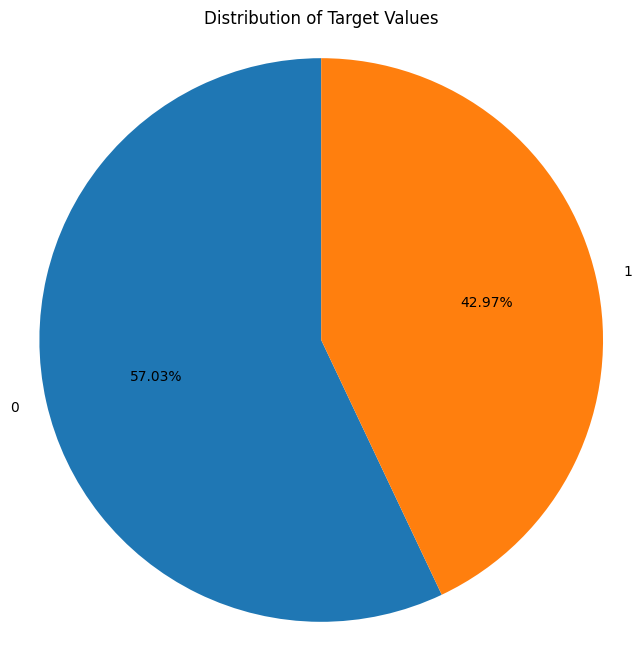

In [17]:
# Calculate the percentage of 1's and 0's in the target column
target_counts = train_df['target'].value_counts(normalize=True) * 100

print("Percentage of entries in the target column:")
print(f"0's: {target_counts[0]:.2f}%")
print(f"1's: {target_counts[1]:.2f}%")

# Optional: Create a pie chart to visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=['0', '1'], autopct='%1.2f%%', startangle=90)
plt.title('Distribution of Target Values')
plt.axis('equal')
plt.show()

### 2.1 RNN Forumulation
We must tokenize the text and convert them to sequences of a padded, fixed length.  
The RNN will be a simple model with an embedding layer, an RNN layer, and a dense layer.

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Prepare the data
X = train_df['text'].values
y = train_df['target'].values

# Tokenize the text
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Create the RNN model
simple_rnn = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    SimpleRNN(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

simple_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
simple_rnn_history = simple_rnn.fit(X_pad, y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = simple_rnn.evaluate(X_pad, y)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/10


/home/drodriq/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.6109 - loss: 4.7665 - val_accuracy: 0.7183 - val_loss: 0.5930
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.7837 - loss: 0.4951 - val_accuracy: 0.7748 - val_loss: 0.4869
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.8757 - loss: 0.3193 - val_accuracy: 0.7886 - val_loss: 0.4671
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9060 - loss: 0.2455 - val_accuracy: 0.7886 - val_loss: 0.4748
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9300 - loss: 0.1812 - val_accuracy: 0.7761 - val_loss: 0.5447
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9502 - loss: 0.1386 - val_accuracy: 0.7787 - val_loss: 0.6860
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9627 - loss: 0.1037 - val_accuracy: 0.7702 - val_loss: 0.6512
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9683 - loss: 0.0880 - val_accuracy: 0.

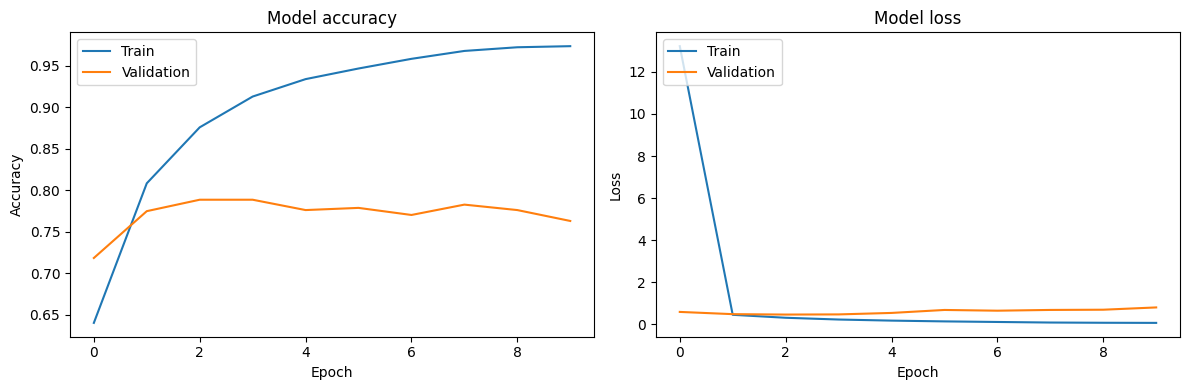

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(simple_rnn_history.history['accuracy'])
plt.plot(simple_rnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(simple_rnn_history.history['loss'])
plt.plot(simple_rnn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
from tensorflow.keras.layers import GRU, Embedding, Dense
from tensorflow.keras.models import Sequential

# Create the GRU model
GRU_model = Sequential([
    Embedding(max_words, 100, input_length=max_len),
    GRU(128, return_sequences=True),
    GRU(64),
    Dense(1, activation='sigmoid')
])

GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = GRU_model.fit(X_pad, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/home/drodriq/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.6599 - loss: 0.6008 - val_accuracy: 0.8004 - val_loss: 0.4583
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8782 - loss: 0.3241 - val_accuracy: 0.7912 - val_loss: 0.4766
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9311 - loss: 0.1958 - val_accuracy: 0.7958 - val_loss: 0.5172
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9547 - loss: 0.1263 - val_accuracy: 0.7722 - val_loss: 0.6567
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9673 - loss: 0.1027 - val_accuracy: 0.7636 - val_loss: 0.6811
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9712 - loss: 0.0763 - val_accuracy: 0.7557 - val_loss: 0.7649
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9774 - loss: 0.0638 - val_accuracy: 0.7459 - val_loss: 0.9356
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9772 - loss: 0.0582 - val_accuracy

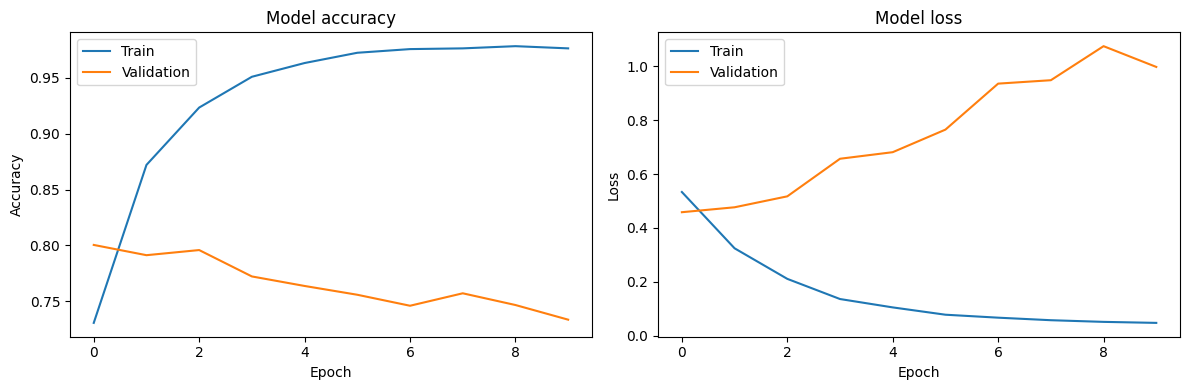

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [24]:
print("SimpleRNN Model Summary:")
simple_rnn.summary()

print("\nGRU Model Summary:")
GRU_model.summary()



SimpleRNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 978,821 (3.73 MB)

 Trainable params: 326,273 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 652,548 (2.49 MB)


GRU Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 128)       │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,376,901 (12.88 MB)

 Trainable params: 1,125,633 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,251,268 (8.59 MB)

In [25]:
# Prepare the test data
X_test = test_df['text'].values
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Generate predictions
predictions = simple_rnn.predict(X_test_pad)
predictions = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame with 'id' and 'target' columns
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})

# Write the DataFrame to a CSV file
submission_df.to_csv('simple_rnn_submission.csv', index=False)

print("Predictions have been written csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
Predictions have been written csv


In [26]:
# Generate predictions
predictions = GRU_model.predict(X_test_pad)
predictions = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame with 'id' and 'target' columns
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})

# Write the DataFrame to a CSV file
submission_df.to_csv('gru_submission.csv', index=False)

print("Predictions have been written csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Predictions have been written csv


In [27]:
!kaggle competitions submit -c nlp-getting-started -f gru_submission.csv -m "Message"

100%|██████████████████████████████████████| 22.2k/22.2k [00:00<00:00, 25.1kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

### Results of GRU Model
Our first GRU model did worse than the simple RNN.  
We will try a more sophisticated GRU model featuirng:
- Bidirectional GRU layers for capturing context in both directions
- Global max and average pooling for feature extraction
- Multiple dense layers with dropout for regularization
- Adam optimizer with learning rate reduction
- Early stopping to prevent overfitting

In [31]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define input
input_layer = Input(shape=(max_len,))

# Embedding layer
embedding_layer = Embedding(max_words, 200, input_length=max_len)(input_layer)

# Bidirectional GRU layers
gru_layer1 = Bidirectional(GRU(128, return_sequences=True))(embedding_layer)
gru_layer2 = Bidirectional(GRU(64, return_sequences=True))(gru_layer1)

# Global pooling layers
max_pooling = GlobalMaxPooling1D()(gru_layer2)
avg_pooling = GlobalAveragePooling1D()(gru_layer2)

# Concatenate pooling layers
concat = concatenate([max_pooling, avg_pooling])

# Dense layers with dropout
dense1 = Dense(128, activation='relu')(concat)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Output layer
output_layer = Dense(1, activation='sigmoid')(dropout2)

# Create model
sophisticated_model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
optimizer = Adam(learning_rate=0.001)
sophisticated_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

sophisticated_model.summary()


/home/drodriq/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 200)  │  2,000,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 100, 256)  │    253,440 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 100, 128)  │    123,648 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_3[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_3[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,418,305 (9.23 MB)

 Trainable params: 2,418,305 (9.23 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model
history = sophisticated_model.fit(
    X_pad, y,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.5932 - loss: 0.6604 - val_accuracy: 0.7787 - val_loss: 0.4709 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.8599 - loss: 0.3693 - val_accuracy: 0.7768 - val_loss: 0.4662 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9132 - loss: 0.2524 - val_accuracy: 0.7682 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9403 - loss: 0.1712 - val_accuracy: 0.7676 - val_loss: 0.5759 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.9708 - loss: 0.1023 - val_accuracy: 0.7538 - val_loss: 0.7834 - learning_rate: 2.0000e-04


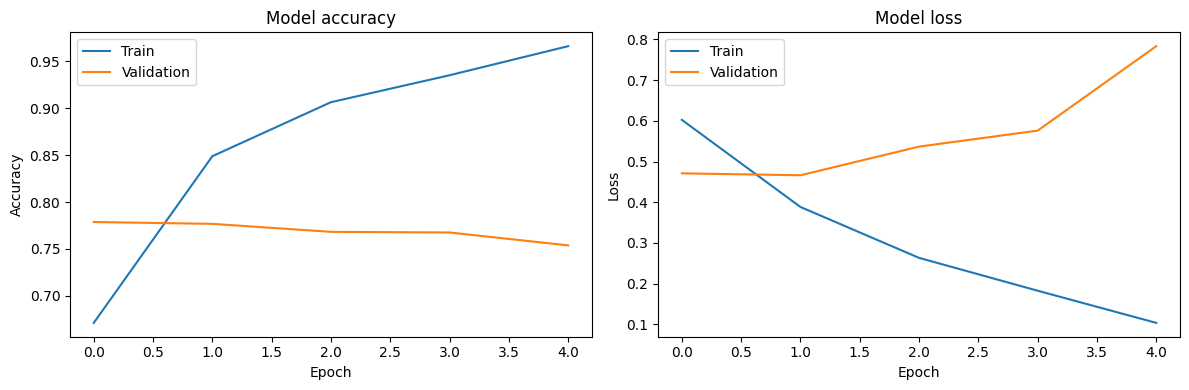

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
# Generate predictions
predictions = GRU_model.predict(X_test_pad)
predictions = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame with 'id' and 'target' columns
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})

# Write the DataFrame to a CSV file
submission_df.to_csv('second_gru_submission.csv', index=False)

print("Predictions have been written csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Predictions have been written csv


In [35]:
!kaggle competitions submit -c nlp-getting-started -f second_gru_submission.csv -m "Message"

100%|██████████████████████████████████████| 22.2k/22.2k [00:01<00:00, 22.3kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

### Results and Conclusions
More sophisticated models did not help us improve the results, and actually caused an inflation of the loss function - indicating overfitting of the data. Since we actually have a small amount of data and each tweet is quites short, we really need to be careful about overfitting.  

I would conjecture a simpler model with more memory will help us. We will try one more model to test this.


### Bonus Model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the LSTM model
model = Sequential([
    Embedding(max_words, 100, input_length=max_len),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_pad, y, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_pad, y)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/5


/home/drodriq/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6731 - loss: 0.6000 - val_accuracy: 0.8045 - val_loss: 0.4431
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8680 - loss: 0.3305 - val_accuracy: 0.8045 - val_loss: 0.4695
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9211 - loss: 0.2192 - val_accuracy: 0.7940 - val_loss: 0.4811
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9432 - loss: 0.1589 - val_accuracy: 0.7533 - val_loss: 0.6227
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9611 - loss: 0.1161 - val_accuracy: 0.7717 - val_loss: 0.6216
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9824 - loss: 0.0648
Test accuracy: 0.9549


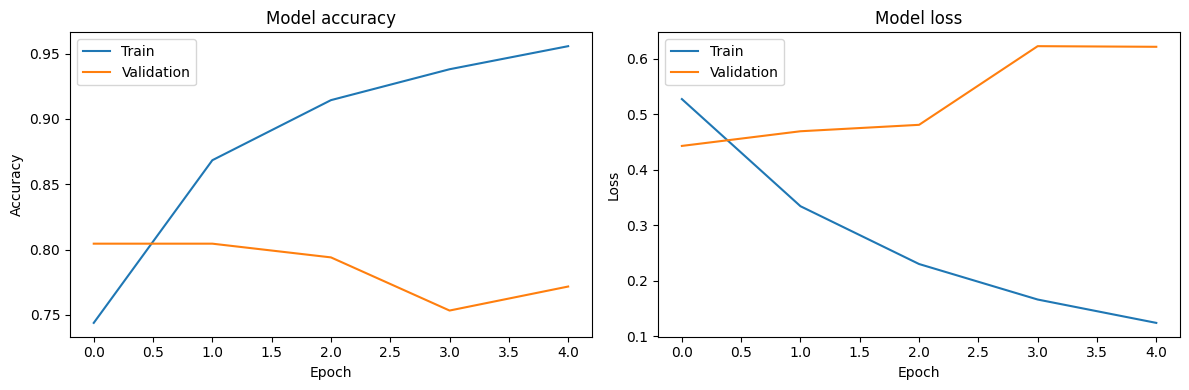

In [43]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [44]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [45]:
# Generate predictions
predictions = model.predict(X_test_pad)
predictions = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame with 'id' and 'target' columns
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})

# Write the DataFrame to a CSV file
submission_df.to_csv('LSTM_Submission.csv', index=False)

print("Predictions have been written csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Predictions have been written csv


In [46]:
!kaggle competitions submit -c nlp-getting-started -f LSTM_Submission.csv -m "Message"

100%|██████████████████████████████████████| 22.2k/22.2k [00:01<00:00, 17.7kB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (20 hours from now).
